In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
from keras.layers import Dense, BatchNormalization, Dropout, LSTM
from keras.models import Sequential
from keras.utils import to_categorical
from keras import callbacks
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score

In [3]:
#loading data
data = pd.read_csv("../input/heart-failure-clinical-data/heart_failure_clinical_records_dataset.csv")
data.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


**About the data:**

* age: Age of the patient
* anaemia: If the patient had the haemoglobin below the normal range
* creatinine_phosphokinase: The level of the creatine phosphokinase in the blood in mcg/L
* diabetes: If the patient was diabetic
* ejection_fraction: Ejection fraction is a measurement of how much blood the left ventricle pumps out with each contraction
* high_blood_pressure: If the patient had hypertension
* platelets: Platelet count of blood in kiloplatelets/mL
* serum_creatinine: The level of serum creatinine in the blood in mg/dL
* serum_sodium: The level of serum sodium in the blood in mEq/L
* sex: The sex of the patient
* smoking: If the patient smokes actively or ever did in past
* time: It is the time of the patient's follow-up visit for the disease in months
* DEATH_EVENT: If the patient deceased during the follow-up period

<AxesSubplot:xlabel='DEATH_EVENT', ylabel='count'>

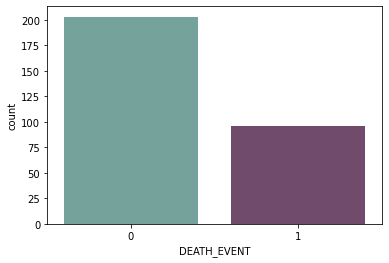

In [5]:
#first of all let us evaluate the target and find out if our data is imbalanced or not
cols= ["#6daa9f","#774571"]
sns.countplot(x= data["DEATH_EVENT"], palette= cols)

Point to note is that there is an imbalance in the data.

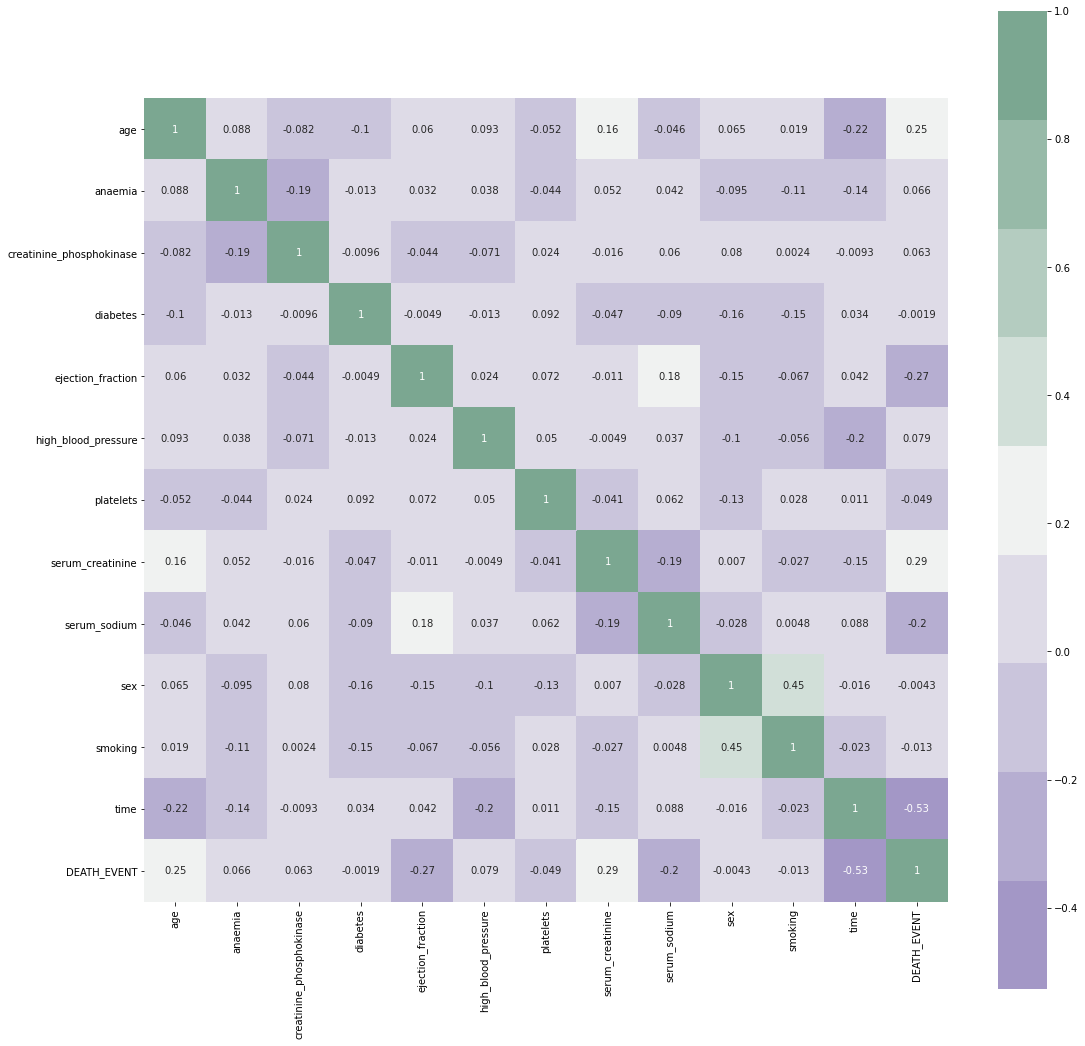

In [6]:
#Examaning a corelation matrix of all the features 
cmap = sns.diverging_palette(275,150,  s=40, l=65, n=9)
corrmat = data.corr()
plt.subplots(figsize=(18,18))
sns.heatmap(corrmat,cmap= cmap,annot=True, square=True);

Text(0.5, 1.0, 'Distribution Of Age')

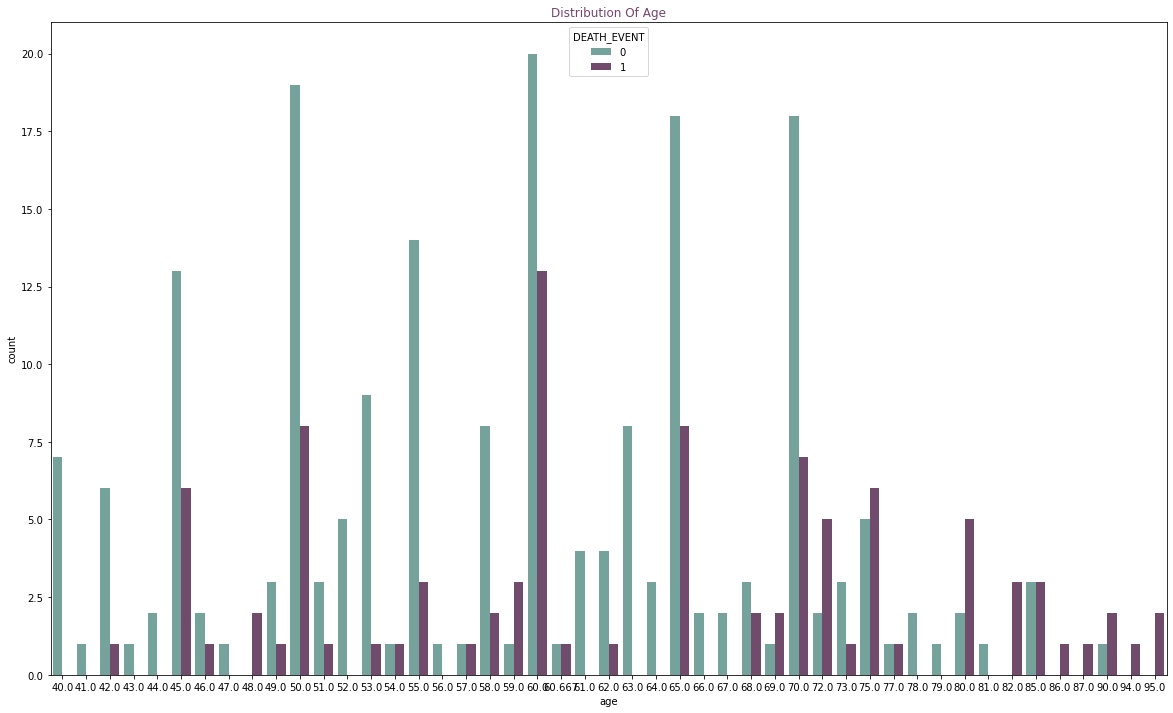

In [7]:
#Evauating age distrivution 
plt.figure(figsize=(20,12))
#colours =["#774571","#b398af","#f1f1f1" ,"#afcdc7", "#6daa9f"]
Days_of_week=sns.countplot(x=data['age'],data=data, hue ="DEATH_EVENT",palette = cols)
Days_of_week.set_title("Distribution Of Age", color="#774571")

I spotted outliers on our dataset. I didn't remove them yet as it may lead to overfitting. Though we may end up with better statistics. In this case, with medical data, the outliers may be an important deciding factor.

Next, we examine the kdeplot of time and age as they both are significant features.

<AxesSubplot:xlabel='time', ylabel='age'>

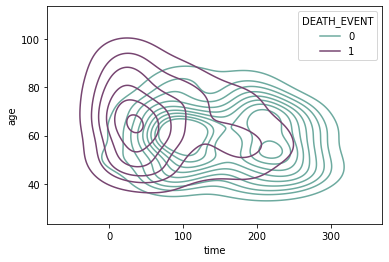

In [9]:
sns.kdeplot(x=data["time"], y=data["age"], hue =data["DEATH_EVENT"], palette=cols)

In [10]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
age,299.0,60.833893,11.894809,40.0,51.0,60.0,70.0,95.0
anaemia,299.0,0.431438,0.496107,0.0,0.0,0.0,1.0,1.0
creatinine_phosphokinase,299.0,581.839465,970.287881,23.0,116.5,250.0,582.0,7861.0
diabetes,299.0,0.418060,0.494067,0.0,0.0,0.0,1.0,1.0
ejection_fraction,299.0,38.083612,11.834841,14.0,30.0,38.0,45.0,80.0
high_blood_pressure,299.0,0.351171,0.478136,0.0,0.0,0.0,1.0,1.0
platelets,299.0,263358.029264,97804.236869,25100.0,212500.0,262000.0,303500.0,850000.0
serum_creatinine,299.0,1.393880,1.034510,0.5,0.9,1.1,1.4,9.4
serum_sodium,299.0,136.625418,4.412477,113.0,134.0,137.0,140.0,148.0
sex,299.0,0.648829,0.478136,0.0,0.0,1.0,1.0,1.0


In [11]:
#assigning values to features as X and target as y
X=data.drop(["DEATH_EVENT"],axis=1)
y=data["DEATH_EVENT"]

In [12]:
#Set up a standard scaler for the features
col_names = list(X.columns)
s_scaler = preprocessing.StandardScaler()
X_df= s_scaler.fit_transform(X)
X_df = pd.DataFrame(X_df, columns=col_names)   
X_df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,299.0,5.265205e-16,1.001676,-1.754448,-0.828124,-0.070223,0.771889,2.877170
anaemia,299.0,3.594301e-16,1.001676,-0.871105,-0.871105,-0.871105,1.147968,1.147968
creatinine_phosphokinase,299.0,3.713120e-18,1.001676,-0.576918,-0.480393,-0.342574,0.000166,7.514640
diabetes,299.0,1.113936e-16,1.001676,-0.847579,-0.847579,-0.847579,1.179830,1.179830
ejection_fraction,299.0,3.341808e-18,1.001676,-2.038387,-0.684180,-0.007077,0.585389,3.547716
high_blood_pressure,299.0,-4.841909e-16,1.001676,-0.735688,-0.735688,-0.735688,1.359272,1.359272
platelets,299.0,1.009969e-16,1.001676,-2.440155,-0.520870,-0.013908,0.411120,6.008180
serum_creatinine,299.0,-2.227872e-18,1.001676,-0.865509,-0.478205,-0.284552,0.005926,7.752020
serum_sodium,299.0,-8.627435e-16,1.001676,-5.363206,-0.595996,0.085034,0.766064,2.582144
sex,299.0,-5.940993e-18,1.001676,-1.359272,-1.359272,0.735688,0.735688,0.735688


In [14]:
#spliting test and training sets
X_train, X_test, y_train,y_test = train_test_split(X_df,y,test_size=0.25,random_state=7)

In [15]:
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True)

# Initialising the NN
model = Sequential()

# layers
model.add(Dense(units = 16, kernel_initializer = 'uniform', activation = 'relu', input_dim = 12))
model.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(units = 4, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
from keras.optimizers import SGD
# Compiling the ANN
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Train the ANN
history = model.fit(X_train, y_train, batch_size = 32, epochs = 500,callbacks=[early_stopping], validation_split=0.2)

Epoch 1/500
6/6 [==============================] - 1s 112ms/step - loss: 0.6929 - accuracy: 0.4982 - val_loss: 0.6922 - val_accuracy: 0.6667
Epoch 2/500
6/6 [==============================] - 0s 11ms/step - loss: 0.6921 - accuracy: 0.6552 - val_loss: 0.6913 - val_accuracy: 0.6667
Epoch 3/500
6/6 [==============================] - 0s 10ms/step - loss: 0.6912 - accuracy: 0.6634 - val_loss: 0.6903 - val_accuracy: 0.6667
Epoch 4/500
6/6 [==============================] - 0s 10ms/step - loss: 0.6904 - accuracy: 0.6502 - val_loss: 0.6894 - val_accuracy: 0.6667
Epoch 5/500
6/6 [==============================] - 0s 11ms/step - loss: 0.6898 - accuracy: 0.6431 - val_loss: 0.6885 - val_accuracy: 0.6667
Epoch 6/500
6/6 [==============================] - 0s 10ms/step - loss: 0.6890 - accuracy: 0.6473 - val_loss: 0.6875 - val_accuracy: 0.6667
Epoch 7/500
6/6 [==============================] - 0s 10ms/step - loss: 0.6877 - accuracy: 0.6491 - val_loss: 0.6865 - val_accuracy: 0.6667
Epoch 8/500
6/6 [==

In [16]:
val_accuracy = np.mean(history.history['val_accuracy'])
print("\n%s: %.2f%%" % ('val_accuracy', val_accuracy*100))


val_accuracy: 78.23%


**Plotting training and validation loss over epochs**

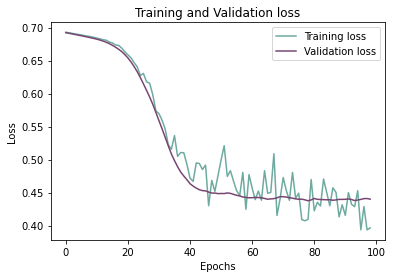

In [17]:
history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['loss']], "#6daa9f", label='Training loss')
plt.plot(history_df.loc[:, ['val_loss']],"#774571", label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="best")

plt.show()

**Plotting training and validation accuracy over epochs**

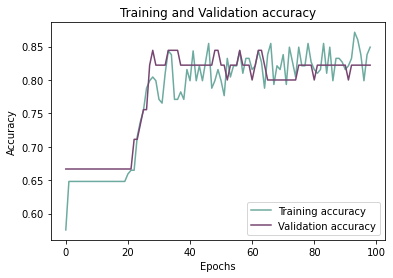

In [18]:
history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['accuracy']], "#6daa9f", label='Training accuracy')
plt.plot(history_df.loc[:, ['val_accuracy']], "#774571", label='Validation accuracy')

plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [19]:
# Predicting the test set results
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)
np.set_printoptions()

<AxesSubplot:>

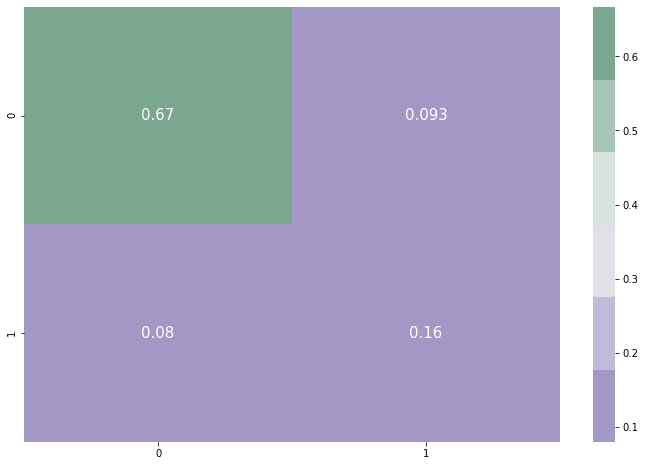

In [20]:
# confusion matrix
cmap1 = sns.diverging_palette(275,150,  s=40, l=65, n=6)
plt.subplots(figsize=(12,8))
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix), cmap = cmap1, annot = True, annot_kws = {'size':15})

In [21]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.88      0.88        57
           1       0.63      0.67      0.65        18

    accuracy                           0.83        75
   macro avg       0.76      0.77      0.77        75
weighted avg       0.83      0.83      0.83        75

